<a href="https://colab.research.google.com/github/EnX-Ayush/Energy_Consumption/blob/main/Energy_ConsumptionWeek3_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install xgboost tensorflow holidays seaborn

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import holidays

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 5]


In [33]:
from google.colab import files

df = pd.read_csv("/content/Energy_consumption.csv")
print("Dataset loaded")
print("Columns in dataset:", df.columns.tolist())
df.head()


Dataset loaded
Columns in dataset: ['Timestamp', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'DayOfWeek', 'Holiday', 'EnergyConsumption']


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [34]:
time_col = None
for c in df.columns:
    if 'time' in c.lower() or 'date' in c.lower():
        time_col = c
        break

if time_col is None:
    time_col = 'Timestamp'

if time_col is None or time_col not in df.columns:
    raise ValueError("Could not find a timestamp column. Please ensure your file has 'time' or 'date' column.")

target_col = 'EnergyConsumption' if 'EnergyConsumption' in df.columns else df.columns[-1]

df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df = df.dropna(subset=[time_col])
df = df.set_index(time_col).sort_index()

numeric_df = df.select_dtypes(include=['number'])
if numeric_df.empty:
    raise ValueError("No numeric columns found! Please check dataset.")

df = numeric_df.resample('H').mean()
df[target_col] = df[target_col].interpolate(method='time').ffill().bfill()

print("After resampling & cleaning:")
print(df.head())

After resampling & cleaning:
                     Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999        5.0   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918        1.0   
2022-01-01 02:00:00    28.704277  58.907658    1755.715009        2.0   
2022-01-01 03:00:00    20.080469  50.371637    1452.316318        1.0   
2022-01-01 04:00:00    23.097359  51.401421    1094.130359        9.0   

                     RenewableEnergy  EnergyConsumption  
Timestamp                                                
2022-01-01 00:00:00         2.774699          75.364373  
2022-01-01 01:00:00        21.831384          83.401855  
2022-01-01 02:00:00         6.764672          78.270888  
2022-01-01 03:00:00         8.623447          56.519850  
2022-01-01 04:00:00         3.071969          70.811732  


/tmp/ipython-input-1664093153.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = numeric_df.resample('H').mean()   # hourly average for numeric data


In [35]:
def add_time_features(data):
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['is_weekend'] = (data.index.dayofweek >= 5).astype(int)
    hols = holidays.CountryHoliday('IN')
    data['is_holiday'] = data.index.to_series().apply(lambda d: 1 if d.date() in hols else 0)
    return data

def add_lag_features(data, target, lags=[1,2,3,24,48,168]):
    data = data.copy()
    for lag in lags:
        data[f"lag_{lag}"] = data[target].shift(lag)
    return data

df = add_time_features(df)
df = add_lag_features(df, target_col)
df = df.dropna()

print("After feature engineering:")
print(df.head())


After feature engineering:
                     Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-08 00:00:00    25.714735  42.298665    1999.204208        1.0   
2022-01-08 01:00:00    20.914792  31.710094    1486.780868        5.0   
2022-01-08 02:00:00    25.205341  48.649901    1533.208172        3.0   
2022-01-08 03:00:00    25.976524  38.484153    1595.427693        4.0   
2022-01-08 04:00:00    27.726414  53.339179    1751.722623        2.0   

                     RenewableEnergy  EnergyConsumption  hour  dayofweek  \
Timestamp                                                                  
2022-01-08 00:00:00        29.565863          75.614982     0          5   
2022-01-08 01:00:00         4.306860          71.789647     1          5   
2022-01-08 02:00:00         4.054743          63.008158     2          5   
2022-01-08 03:00:00        16.205204          94.550625     3          5   
2022-

In [36]:
test_size = int(0.15 * len(df))
train_df = df.iloc[:-test_size]
test_df = df.iloc[-test_size:]

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train/Test split complete:")
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


Train/Test split complete:
Train samples: 708, Test samples: 124


In [37]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    early_stopping_rounds=20  # <-- put here
)

xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [38]:
seq_len = 24

features = df.drop(columns=[target_col])
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)

def create_sequences(scaled_df, target_series, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(scaled_df)):
        Xs.append(scaled_df.iloc[i-seq_len:i].values)
        ys.append(target_series.iloc[i])
    return np.array(Xs), np.array(ys)

X_all, y_all = create_sequences(scaled_df, df[target_col], seq_len)
split = int(len(X_all) * 0.85)
X_train_seq, X_test_seq = X_all[:split], X_all[split:]
y_train_seq, y_test_seq = y_all[:split], y_all[split:]

print(f"LSTM data ready — Train shape: {X_train_seq.shape}, Test shape: {X_test_seq.shape}")


LSTM data ready — Train shape: (686, 24, 16), Test shape: (122, 24, 16)


Training LSTM model
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6052.2393 - mae: 77.3714 - val_loss: 6262.8774 - val_mae: 78.6673
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5539.0942 - mae: 73.9395 - val_loss: 6301.4844 - val_mae: 78.9132
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4275.0034 - mae: 64.7256 - val_loss: 6267.6587 - val_mae: 78.6984
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3088.7603 - mae: 54.6058 - val_loss: 6246.6060 - val_mae: 78.5643
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2146.7844 - mae: 44.8432 - val_loss: 5853.7866 - val_mae: 75.3949
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1217.2537 - mae: 33.3295 - val_loss: 2584.1338 - val_mae: 44.0056
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 623.8799 - mae: 23.2314 - val_loss: 1900.2942 - val_mae: 33.5485
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 297.1440 - mae: 14.9155 - val_loss: 1754.8508 - val_mae: 29.0920
Epoch 9/50
20

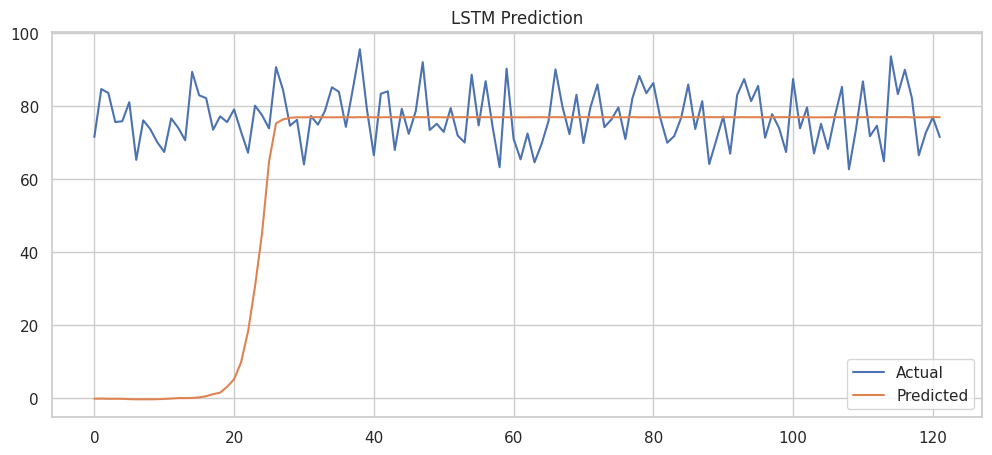

In [39]:
print("Training LSTM model")

tf.random.set_seed(42)
model = Sequential([
    LSTM(64, input_shape=(seq_len, X_train_seq.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(X_train_seq, y_train_seq,
                    validation_split=0.1,
                    epochs=50, batch_size=32, verbose=1,
                    callbacks=[es])

lstm_pred = model.predict(X_test_seq).flatten()

mae_lstm = mean_absolute_error(y_test_seq, lstm_pred)
mse_lstm = mean_squared_error(y_test_seq, lstm_pred)
rmse_lstm = np.sqrt(mse_lstm)

print(f"LSTM → MAE: {mae_lstm:.3f}, RMSE: {rmse_lstm:.3f}")

plt.plot(y_test_seq, label="Actual")
plt.plot(lstm_pred, label="Predicted")
plt.legend(); plt.title("LSTM Prediction"); plt.show()


In [40]:
mae_lstm = mean_absolute_error(y_test_seq, lstm_pred)
mse_lstm = mean_squared_error(y_test_seq, lstm_pred)
rmse_lstm = np.sqrt(mse_lstm)

print("LSTM Results:")
print("MAE:", mae_lstm)
print("RMSE:", rmse_lstm)


LSTM Results:
MAE: 19.800181661195573
RMSE: 33.60443606641823
